## _Track Performance_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import time

In [4]:
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial
from utils_plot import make_cmp_plot, pt_configs, eta_configs, get_ratio

In [5]:
sys.path.append('..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### _Read Particles HDF5 Store_

In [6]:
path = "../run_all/fwp_gnn_segmenting/eval/all_particles.h5"
store = pd.HDFStore(path)

In [7]:
# store.get('data').head()
df = store['data']

In [8]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,6,0.205157,-1.854500,-0.415320,8.052530,1,2212,0.211190,2.244420,2.951081,8,True,True,0
1,5,0.128648,2.395160,0.536402,6.411090,1,211,0.991597,0.614596,-0.528416,16,True,True,0
0,5,0.101602,-1.338330,1.013940,8.682130,1,211,0.374578,1.663314,1.566344,11,True,True,1
1,6,0.275242,0.134011,-0.101529,0.468718,1,2212,0.473503,1.421811,-0.582538,14,True,True,1
0,5,0.114144,1.320080,0.160395,18.215401,1,211,0.503124,1.358655,-0.031754,23,True,True,10


In [9]:
outdir = "./"
out_prefix = "all"

In [10]:
# Filtering: We can filter charge, pdgcode vs Tracking efficiency
# df = df[df['pdgcode'].isin([-211, 211])].reset_index(drop=True)
# df = df[df['pdgcode'].isin([-2212, 2212])].reset_index(drop=True)
# df = df[df['pdgcode'].isin([211])].reset_index(drop=True)
# df = df[df['q'] == 1].reset_index(drop=True)

In [11]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,6,0.205157,-1.854500,-0.415320,8.052530,1,2212,0.211190,2.244420,2.951081,8,True,True,0
1,5,0.128648,2.395160,0.536402,6.411090,1,211,0.991597,0.614596,-0.528416,16,True,True,0
0,5,0.101602,-1.338330,1.013940,8.682130,1,211,0.374578,1.663314,1.566344,11,True,True,1
1,6,0.275242,0.134011,-0.101529,0.468718,1,2212,0.473503,1.421811,-0.582538,14,True,True,1
0,5,0.114144,1.320080,0.160395,18.215401,1,211,0.503124,1.358655,-0.031754,23,True,True,10


In [50]:
df.n_true_hits > 6

0     True
1     True
0     True
1     True
0     True
1     True
0     True
1     True
2     True
3     True
0     True
1     True
2     True
3     True
0    False
1     True
2     True
0     True
1     True
2    False
3     True
0     True
1     True
2     True
3     True
0     True
1     True
2     True
0     True
1     True
0     True
1     True
0     True
1     True
0     True
1     True
2     True
3     True
0     True
1     True
2     True
0     True
1    False
0     True
1     True
2    False
0     True
1     True
0     True
1     True
2     True
0     True
1     True
0     True
1     True
2     True
Name: n_true_hits, dtype: bool

In [51]:
pt = df.pt.values
peta = df.peta.values
vx = df.vx.values
vy = df.vy.values
d0 = np.sqrt(vx**2 + vy**2)
z0 = df.vz.values
ptheta = (df.ptheta.values*180)/np.pi   # radians to degrees
pphi = (df.pphi.values*180)/np.pi       # radians to degrees

rectable_idx = df.is_trackable
matched_idx = df.is_matched
n_true_hits = df.n_true_hits

In [14]:
# plot the efficiency as a function of pT, eta
make_cmp_plot_fn = partial(make_cmp_plot,
                           legends=["Selected", "Reconstructable", "Matched"],
                           ylabel="Events", ratio_label='Track Efficiency',
                           ratio_legends=["Tracking Efficiency (phys.)", "Tracking Efficiency (tech.)"])
                           # ratio_legends=[r"$\epsilon$", r"$\epsilon_{tech.}$"])

## _Overall Efficiencies_

In [15]:
# Lets find Phys. and Tech. Efficicencies
gen_pt = pt
true_pt = pt[rectable_idx]
reco_pt = pt[rectable_idx & matched_idx]

In [16]:
gen_pt.shape[0], true_pt.shape[0], reco_pt.shape[0]

(56, 52, 49)

In [47]:
# Physics Efficiency
reco_pt.shape[0]/gen_pt.shape[0]*100

87.5

In [48]:
# Technical Efficiency
reco_pt.shape[0]/true_pt.shape[0]*100

94.23076923076923

In [ ]:
track_pt = pt[]

### _1. Tranverse Momentum_

In [18]:
min(pt), max(pt)

(0.034445472, 0.3249291)

In [19]:
pt_bins = np.linspace(0.0, 0.60, num=20)   # will give 15 bins

pt_configs = {
    'bins': pt_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}

cut_pt: 0.0


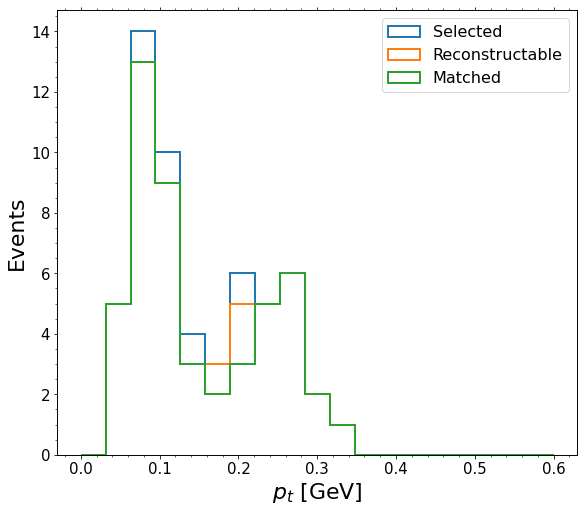

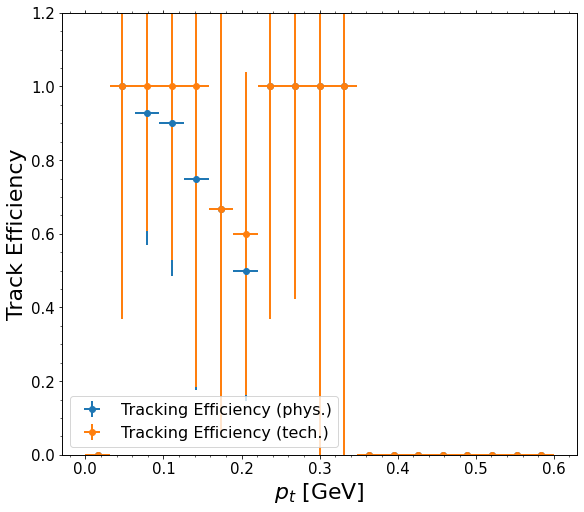

In [20]:
# vertex cuts
all_cuts = [0.0]

for (cut_pt) in all_cuts:
    print("cut_pt: {}".format(cut_pt))

    cuts = (pt > cut_pt)

    # make pt plots
    gen_pt = pt[cuts]
    true_pt = pt[cuts & rectable_idx]
    reco_pt = pt[cuts & rectable_idx & matched_idx]
    
    
    
    make_cmp_plot_fn([gen_pt, true_pt, reco_pt], 
        configs=pt_configs, xlabel=r"$p_t$ [GeV]",
        outname=os.path.join(outdir, "{}_pt_cut{}".format(out_prefix, cut_pt)),
        ymin=0.6)

### _2. Theta Angle_

In [21]:
min(ptheta), max(ptheta)

(10.225181, 76.20566)

In [22]:
ptheta_bins = np.linspace(22, 142, num=20)

ptheta_configs = {
    'bins': ptheta_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}

cut_ptheta: 0.0


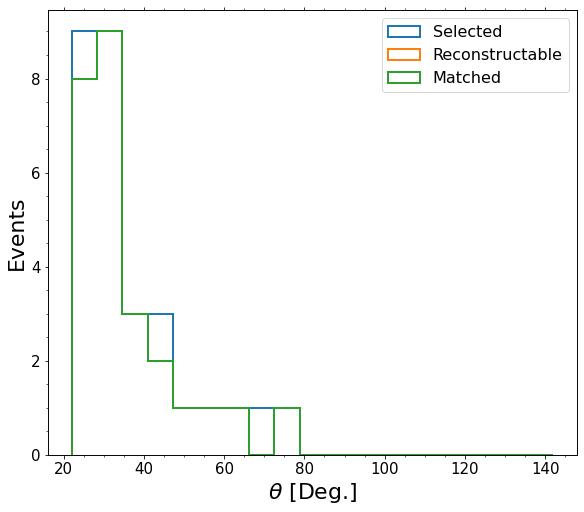

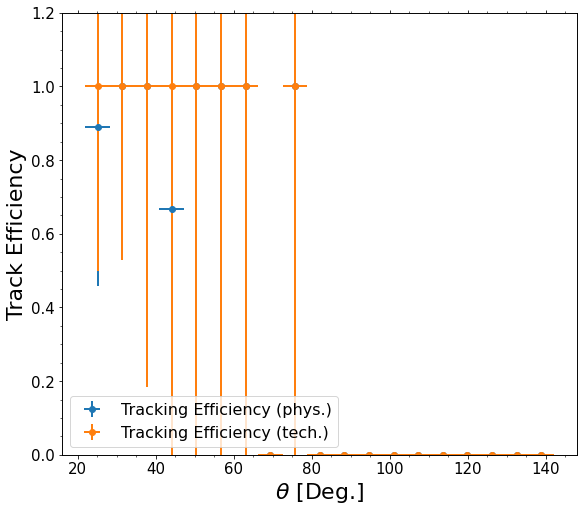

In [23]:
# vertex cuts
all_cuts = [0.0]

for (cut_ptheta) in all_cuts:
    print("cut_ptheta: {}".format(cut_ptheta))

    cuts = (ptheta > cut_ptheta)

    # make pt plots
    gen_ptheta  = ptheta[cuts]
    true_ptheta = ptheta[cuts & rectable_idx]
    reco_ptheta = ptheta[cuts & rectable_idx & matched_idx]

    make_cmp_plot_fn([gen_ptheta, true_ptheta, reco_ptheta], 
        configs=ptheta_configs, xlabel=r"$\theta$ [Deg.]",
        outname=os.path.join(outdir, "{}_ptheta_cut{}".format(out_prefix, cut_ptheta)),
        ymin=0.6)

### _3. Phi Angle_

In [24]:
min(pphi), max(pphi)

(-173.68057, 177.74286)

In [25]:
pphi_bins = np.linspace(-80, 180, num=20)

pphi_configs = {
    'bins': pphi_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}

cut_pphi: 0.0


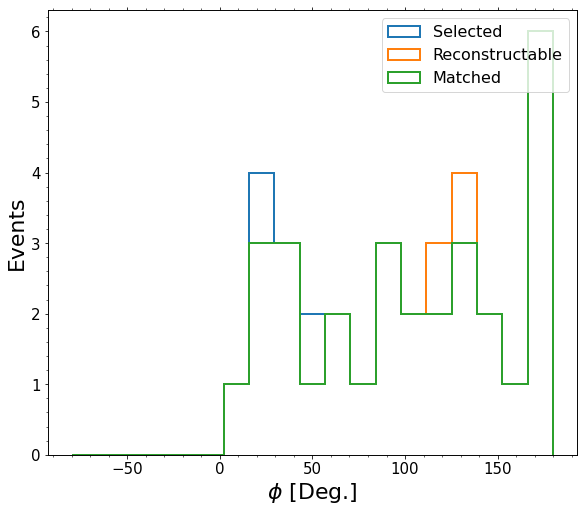

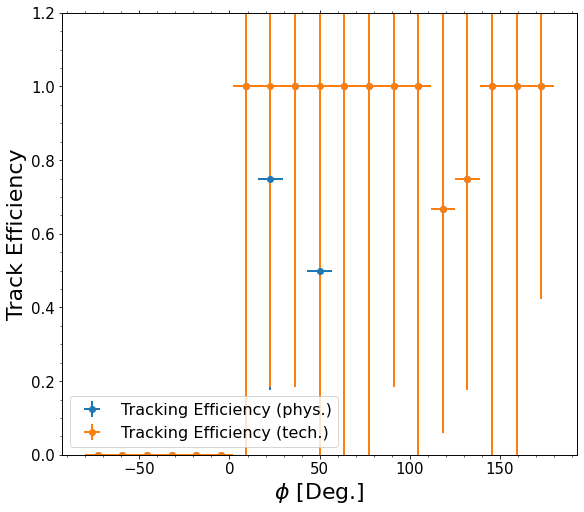

In [26]:
# vertex cuts
all_cuts = [0.0]

for (cut_pphi) in all_cuts:
    print("cut_pphi: {}".format(cut_pphi))

    cuts = (pphi > cut_pphi)

    # make pt plots
    gen_pphi  = pphi[cuts]
    true_pphi = pphi[cuts & rectable_idx]
    reco_pphi = pphi[cuts & rectable_idx & matched_idx]

    make_cmp_plot_fn([gen_pphi, true_pphi, reco_pphi], 
        configs=pphi_configs, xlabel=r"$\phi$ [Deg.]",
        outname=os.path.join(outdir, "{}_pphi_cut{}".format(out_prefix, cut_pphi)),
        ymin=0.6)

### _4. Decay Vertex_

In [27]:
min(d0), max(d0)

(0.034076296, 10.595353)

In [28]:
d0_bins = np.linspace(0.0, 15, num=15)   # will give 15 bins

d0_configs = {
    'bins': d0_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}

cut_d0: 0.0


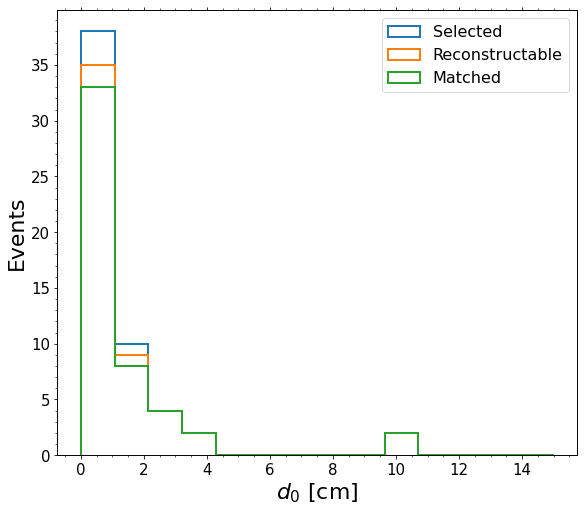

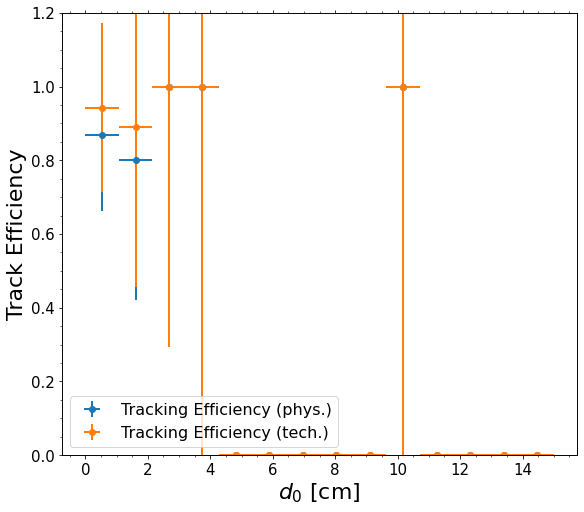

In [29]:
# vertex cuts
all_cuts = [0.0]

for (cut_d0) in all_cuts:
    print("cut_d0: {}".format(cut_d0))

    cuts = (d0 > cut_d0)

    # make pt plots
    gen_d0  = d0[cuts]
    true_d0 = d0[cuts & rectable_idx]
    reco_d0 = d0[cuts & rectable_idx & matched_idx]

    make_cmp_plot_fn([gen_d0, true_d0, reco_d0], 
        configs=d0_configs, xlabel=r"$d_0$ [cm]",
        outname=os.path.join(outdir, "{}_d0_cut{}".format(out_prefix, cut_d0)),
        ymin=0.6)

### _Recreate the Summary from Track Evalution Script_

In [30]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,6,0.205157,-1.854500,-0.415320,8.052530,1,2212,0.211190,2.244420,2.951081,8,True,True,0
1,5,0.128648,2.395160,0.536402,6.411090,1,211,0.991597,0.614596,-0.528416,16,True,True,0
0,5,0.101602,-1.338330,1.013940,8.682130,1,211,0.374578,1.663314,1.566344,11,True,True,1
1,6,0.275242,0.134011,-0.101529,0.468718,1,2212,0.473503,1.421811,-0.582538,14,True,True,1
0,5,0.114144,1.320080,0.160395,18.215401,1,211,0.503124,1.358655,-0.031754,23,True,True,10


- _Physics Efficiency_

In [31]:
n_true_tracks = df.shape[0]
n_matched_true_tracks = df[df.is_matched].shape[0]
print("Tracking Efficiency (Phys.): {:>5.3f}%".format(100 * n_matched_true_tracks/n_true_tracks))

Tracking Efficiency (Phys.): 89.286%


In [32]:
df.shape[0], df.is_matched.shape[0], df.is_trackable.shape[0]

(56, 56, 56)

In [33]:
df[df.is_matched].shape[0]

50

- _Technical Efficiency_

In [34]:
n_reco_tracks = df[df.is_trackable & df.is_matched].shape[0]
n_matched_true_tracks = df[df.is_matched].shape[0]
print("Tracking Efficiency (Tech.): {:>5.3f}%".format(100 * n_matched_true_tracks/n_reco_tracks))

Tracking Efficiency (Tech.): 102.041%


In [35]:
# how to get n_reco_tracks?
# n_reco_tracks = 26439

In [36]:
df[df.is_matched].shape[0]

50

In [37]:
df[df.is_trackable].shape[0]

52

In [38]:
df[df.is_trackable & df.is_matched].shape[0]

49

- _Plotting Efficiency_

In [39]:
import math

In [40]:
pt_bins = np.linspace(0.0, 0.60, num=20)   # will give 15 bins

pt_configs = {
    'bins': pt_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}

In [41]:
def plot_pt_eff(particles):
    """Phys Eff: pt vs reco_pt, Tech Eff: true_pt vs reco_pt"""
    
    pt = particles.pt.values
    gen_pt = pt
    true_pt = pt[particles["is_trackable"]]
    reco_pt = pt[particles["is_trackable"] & particles["is_matched"]]

    # Get histogram values of true_pt and reco_pt
    true_vals, true_bins = np.histogram(true_pt, bins=pt_bins)    # change gen_pt, true_pt to get phys/tech eff.
    reco_vals, reco_bins = np.histogram(reco_pt, bins=pt_bins)

    # Plot the ratio of the histograms as an efficiency
    eff, err = get_ratio(reco_vals, true_vals)
    print(eff)
    xvals = (true_bins[1:] + true_bins[:-1]) / 2
    xerrs = (true_bins[1:] - true_bins[:-1]) / 2

    fig, ax = plt.subplots(figsize=(8,6))
    ax.errorbar(xvals, eff, xerr=xerrs, yerr=err, fmt='o', label='Efficiency')
    
    # Add x and y labels
    ax.set_xlabel('$p_t [GeV]$', fontsize=20)
    ax.set_ylabel('Track Efficiency', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    # ax.set_xlim(-41, 41)
    ax.set_ylim(0, 1.2)
    # ax.legend(fontsize=20, loc='best')
    ax.grid(False)
    fig.tight_layout()
    # fig.savefig("eff.pdf")

[0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


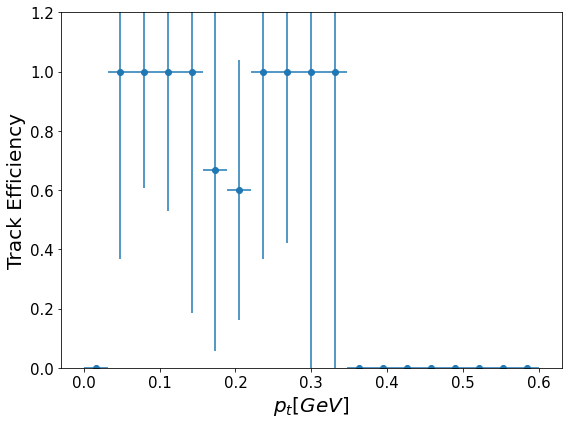

In [42]:
plot_pt_eff(df)

In [43]:
store.close()